# Disclaimer
Once more I will work on this alone. I am aware that I am not allowed to do so for the project assignment, but for now I will have to. Anyways, all is done by me, Kasper Brun.

# Part 1: Mixing Patterns and Assortativity
First, for this part we need our dataset from week 4.

In [1]:
import numpy as np
np.set_printoptions(precision=4,suppress= True)
import json
import networkx as nx
from networkx.readwrite import json_graph
with open('Week4.json') as f:
    data = json.load(f)

G = json_graph.node_link_graph(data)

Due to issues with the API process of assignment 1 this graph only contains 983 nodes of 2113, and the "top fields" assigned to each node (author) is essentially just randomly sampled from one of the papers they are accredited in the papers data set resulting in 17 different fields being represented. One (and only one) random paper they appeared in was chosen and a random element from the list of fields was chosen.

In [2]:
#It is presumed it is not the average's average that is wished,
#but the average if counting all of them, i.e.
#total in the same field divided by total amount of collaborations
def avg_calc(G):
    collab_count = 0
    field_count = 0

    for author in G.nodes():
        #Getting the "neighbours" of the author, i.e. those they collaborated with

        collabs = list(G.neighbors(author))
        collab_count += len(collabs)

        #Some authors have no collaborators. No need to spend more time operation
        #time on them
        if len(collabs) == 0:
            break

        #Searching through collabs
        for i in range(len(collabs)):
            if G.nodes[author]["Fields"] == G.nodes[collabs[i]]["Fields"]:
                field_count += 1
    return field_count/collab_count
avg = avg_calc(G)
print(f"Average amount of collaborators with the same top field is {avg}")

Average amount of collaborators with the same top field is 0.373581847649919


* Create a new graph, with the same nodes and edges, but where the association between nodes and field is shuffled. Compute the measure above for this randomized graph.

* Repeat the point above 100 times (at least). Plot the distribution of the values obtained and compare it with the value you have found for the real graph. Is the chance to connect to a member of the same field significantly higher than it would be by chance?

For this I will use the 'double_edge_swap' function of NetworkX that will shuffle the edges while maintaing the degrees

In [3]:
G2 = G.copy()
G2 = nx.double_edge_swap(G2,len(G.edges())*2, len(G.edges())*4, 2244)
print("Average of the shuffled graph is", avg_calc(G2))

Average of the shuffled graph is 0.24716369529983792


This process is repeated 500 times.

In [4]:
avg_count = [] #storing the results
n = 500

for i in range(n):
    G2 = nx.double_edge_swap(G2,len(G.edges())*2, len(G.edges())*4, 2244)
    avg_count.append(avg_calc(G2))

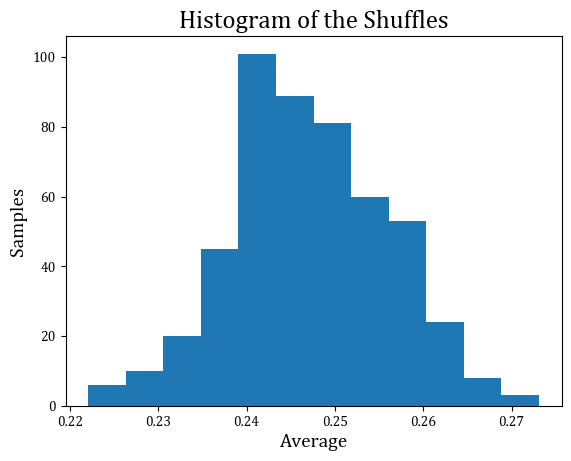

Mean of the shuffles is 0.24710210696920562


In [5]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.rcParams['font.family'] = 'Cambria'
plt.title("Histogram of the Shuffles",fontsize=18)
plt.ylabel("Samples",fontsize=14)
plt.xlabel("Average",fontsize=14)
plt.hist(avg_count,bins=12)
plt.title
plt.show()
print("Mean of the shuffles is",sum(avg_count)/len(avg_count))

Quite clearly the average of the samples is considerable lower than the non-shuffled. This obviously begs two questions: 1) Is there something wrong with the method of sampling? While I cannot rule this out, I can say I have checked both the seed and the random choice module, which seem to work as intended. 2) Is this significantly different? The t-test is the suitable test as we are working with averages.

In [6]:
from scipy.stats import ttest_1samp
#T-test
t_statistic, p_value = ttest_1samp(avg_count, avg)
print("t-statistic: ", t_statistic)
print("p-value: ", p_value)

t-statistic:  -320.5294358783768
p-value:  0.0


Unsurprisingly the t-test confirms the suspicion of their being a non-existant chance of this being random, and thus the chance to connect with a member of the same field is not random. With that said I initially introduced a lot of randomness into the data set due my issues with the Semantic Scholar API. Though, even when picking at random, it was still a pick of a paper the author collaborated on which was likely to also be within their topfield, so while the choice was random it was still favoured to pick their top field as opposed to picking from all the fields present in the paper database. Furthermore, it is not a complete surprise either that people working within the same fields are more likely to collaborate - even in a interdisciplinary field like computational social science. To further investigate this I will compute the assortativity coefficient

# 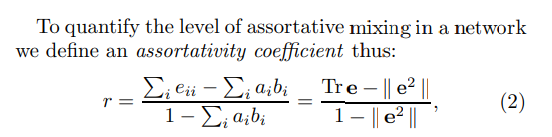

They sorting matrix is computed by ranking, and for degree that would leave a numerical value to evaluate with, however, for our case there is no "natural" ordering of our fields. This means the result will be a symmetrical matrix.

source: https://arxiv.org/pdf/cond-mat/0209450.pdf

In [7]:
#Setting up the attributes. Used to determine placement in the matrix.
atb = 'Fields'
atb_values = list(set(nx.get_node_attributes(G, atb).values()))

#Setting up the matrix
M = np.zeros((len(atb_values),len(atb_values)))

#Going through our edges and assigning 1/2 to the each node in the edge
for u, v in G.edges():
    i = atb_values.index(G.nodes[u][atb])
    j = atb_values.index(G.nodes[v][atb])
    M[i, j] += 1/2
    M[j, i] += 1/2

M = M / len(list(G.edges()))

#I suppose these are the same for this case. c'est la vie.
a_i = np.array([sum(M[i]) for i in range(len(atb_values))])
b_i = np.array([sum(M[i,:]) for i in range(len(atb_values))])

#Left is to calulate the assoritativity coefficient
r = (np.diag(M).sum() - a_i @ b_i)/(1-a_i @ b_i)

print("The assoritativity coefficient of the network is with regards to field is", r)

The assoritativity coefficient of the network is with regards to field is 0.17398727817516885


* Compute the assortativity coefficient with respect to author's field. How do you interpret the value you obtain? (Hint: See this paper, eq (2)). Important: here I do not want you to use the NetworkX implementation, but rather to implement your own version of the measure.

   and to answer the question. With the assortativity coefficient ranging between 1 and -1, where 1 indicates authors only collaborate with others with the same top field and -1 they never cooperate with their own top field. With no set in stone interpretation for the assortative coefficient, it is expected to be positive but with the result of the t-test in mind it seems to be a low assortativity.

* Is the graph assortative with respect to the degree? (e.g. do high-degree scientists tend to link to other high-degree scientists, and low-degree scientists to other low-degree scientists?). Provide an interpretation of your answer.

In [8]:
r = nx.degree_assortativity_coefficient(G)
print(r)

0.08312505492809671


This indicates that there is a small, but close to random, tendency for authors to work with other authors of high degree. One one hand it would be expected for researchers (as these authors are) to branch out and have wide collaborations, and on the other hand it could be speculated if it would be a rich gets richer, and once you are know within a research community, you would be more likely to work with equally known people (high degree). The latter apparently proves untrue, but it could also be speculated they would cooperate more with equally known people, but in the process also branch out to low degree authors.

# Part 2: Communities

* Visualize the graph using netwulf. Set the color of each node based on the club split (the information is stored as a node attribute).

In [9]:
import netwulf as nw

# Create a network
G = nx.karate_club_graph()

node_color = ['#85c3b6' if G.nodes[v]['club'] == 'Mr. Hi' else '#123e70' for v in G.nodes()]
color_dict = {v: node_color[i] for i, v in enumerate(G.nodes())}
nx.set_node_attributes(G, color_dict, 'color')

# node_size = [d * 100000 for n, d in G.degree()]
# for node in G.nodes:
#     G.nodes[node]["size"] = node_size[node]
    
# node_weight = [d for n, d in G.edges()]
# for node in G.nodes:
#     G.nodes[node]["weight"] = node_weight[node]

#nw.visualize(G)

* Write a function to compute the modularity of a graph partitioning (use equation 9.12 in the book). The function should take a networkX Graph and a partitioning as inputs and return the modularity.

# 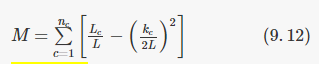

# 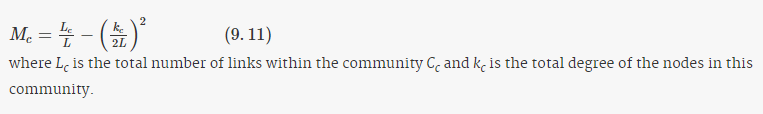

In [10]:
G = nx.karate_club_graph()

def modularity(G, partition):
    #Getting the total egdes
    M = 0
    L = len(G.edges())

    #Adding partition
    nx.set_node_attributes(G, partition, 'partition')
    
    #Looping through the partitions
    for c in set(partition.values()):
        # To more easily handle the L_c and K_c a subgraph is created. 
        subgraph = G.subgraph([node for node in partition if partition[node] == c])

        #print(list(set(nx.get_node_attributes(subgraph, "partition").values()))

        #L_c - amount of links (edges)
        L_c = len(subgraph.edges())
        
        #K_c - sum of degrees in the network.
        #Dividing by two because the network is undirected
        d = dict(subgraph.degree())
        d_keys = dict(subgraph.degree()).keys() #degrees
        K_c = sum([d[x] for x in d])/2

        
        M += L_c/L - (K_c / (2*L) ) ** 2
    return M

part = nx.get_node_attributes(G, "club")
real_mod = modularity(G,part)
print(real_mod)

0.766559829059829


##### This was my attempt, but something is not right. Using this code does not generate the right result, nor does it change values when swapping edges. WIll use the python-Louvain.

In [11]:
import community
G = nx.karate_club_graph()
club_part = nx.get_node_attributes(G, "club")
modular = community.modularity(club_part, G)
print("Real modularity of the partition is",modular)

Real modularity of the partition is 0.39143756676224206


# 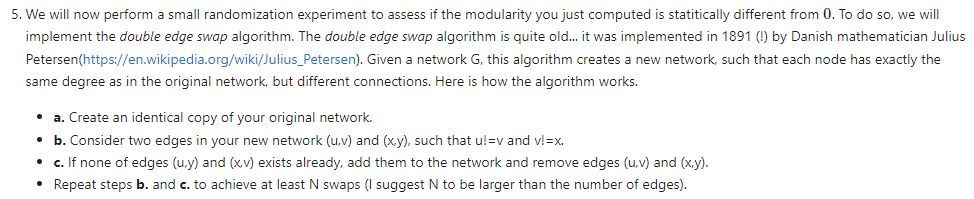

In [12]:
import random 
def double_edge_swap(G):
    N = 0 #swapcounter
    G_c = G.copy()
    while N < len(G.edges()):
        G_cl = list(G_c.edges())
        #Initilization
        #Pulling two random edges
        r1,r2 = random.sample(list(G_c.nodes()), 2)
        e1,e2 = G_cl[r1],G_cl[r2]

        # Checking for condition b
        if e1[0] != e1[1] and e1[1] != e2[0]:
            #checking for condition c
            if G_c.has_edge(e1[0],e2[1]) == False and G_c.has_edge(e2[0],e1[1]) == False:
                G_c.add_edges_from([(e1[0],e2[1]), (e2[0],e1[1])])
                G_c.remove_edges_from([(e1[0], e1[1]), (e2[0], e2[1])])
                N += 1
    return G_c

In [13]:
#Testing if the degree is the same
print("In the original the total of degrees are", sum(dict(G.degree()).values()))

G2 = double_edge_swap(G)
print("After double_edge_swap the total of degrees are", sum(dict(G2.degree()).values()))
print("success!")

In the original the total of degrees are 156
After double_edge_swap the total of degrees are 156
success!


# 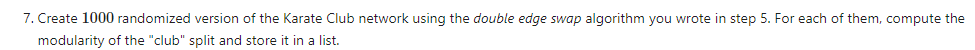

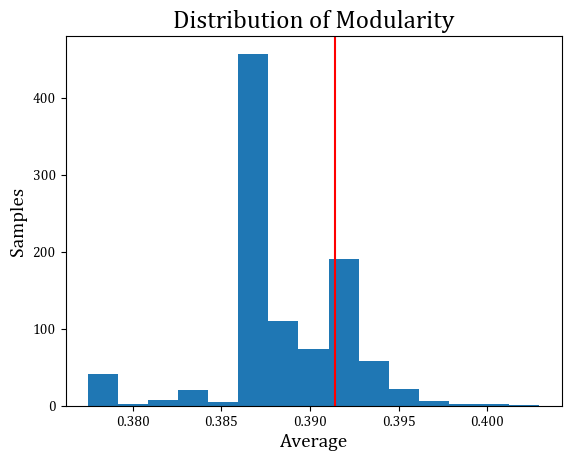

In [14]:
M_list = []

for i in range(1000):
    obj = double_edge_swap(G)
    M_list.append(community.modularity(part, obj))

mod_avg = np.mean(M_list)
mod_std = np.std(M_list)

plt.rcParams['font.family'] = 'Cambria'
plt.title("Distribution of Modularity",fontsize=18)
plt.ylabel("Samples",fontsize=14)
plt.xlabel("Average",fontsize=14)
#plt.plot(M_list,np.arange(1,len(M_list)+1),"o")
plt.hist(M_list,bins=15)
plt.axvline(modular,color="r")
plt.title
plt.show()

# 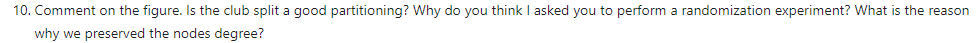

By preserving the nodes degree we maintain the authors influence in the network ensuring 


# 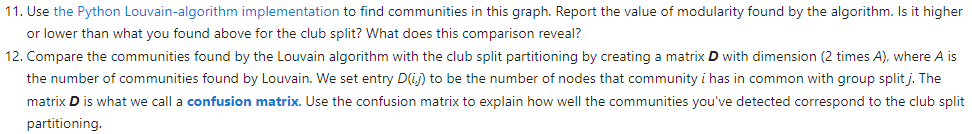

In [15]:
# Find communities using the Louvain algorithm
club_part = nx.get_node_attributes(G, "club")
partition = community.best_partition(G)
modular = community.modularity(partition, G)
partition
print("Modularity for partition using Louvain algorithm:", modular)
print("Modulartiy for partition using clubs:",community.modularity(club_part, G))

Modularity for partition using Louvain algorithm: 0.4438541256723075
Modulartiy for partition using clubs: 0.39143756676224206


In [16]:
#Creating D
A= len(set(partition.values()))
D = np.zeros((2,A))

#Easier for me to work with lists
cp_list = list(club_part.values())
lp_list = list(partition.values())

for i in range(len(cp_list)):
        #Assigning c a value for index. lp already fits.
        if cp_list[i] == "Mr. Hi":
            c = 0
        else:
            c = 1
        D[c][lp_list[i]] += 1
print(D)
print("Confusion matrix where first row is Mr. Hi and second row Officer")

[[11.  1.  5.  0.]
 [ 0. 13.  0.  4.]]
Confusion matrix where first row is Mr. Hi and second row Officer


# The confusion matrix shows that the louvain partitioning is bordering being a subsegmenation of the club segmentation with only 1 node of being split differently. Other than that, the main segment of Mr. Hi and Officer are maintained but those are then split into two segments each of 11 and 5 and 11 and 6 respectively.  MANGLER NOGET

* Use the Python Louvain-algorithm implementation to find communities. How many communities do you find? What are their sizes? Report the value of modularity found by the algorithm. Is the modularity significantly different than 0?

In [17]:
#Loading network again
with open('Week4.json') as f:
    data = json.load(f)

G = json_graph.node_link_graph(data)

#Louvain to partition
partition = community.best_partition(G)
nx.set_node_attributes(G, partition, 'community')

#Amount of communities
n_com = len(set(partition.values()))
print("Communities found by louvain", n_com)

#Modularity
modular = community.modularity(partition, G)
print(modular)

#How many in each community
v_count = {}
for v in partition.values():
    if v in v_count:
        v_count[v] += 1
    else:
        v_count[v] = 1
vc_list = list(v_count.values())

print("\nHighest amount of nodes in a community is", max(vc_list))
print("Lowest amount of nodes in a community is", min(vc_list))
print("Average amount of nodes in a community is", np.mean(vc_list))
print("Median of nodes in a community is", np.median(vc_list))
print("The standard deviation of the partition is",np.std(vc_list))

# a = nx.get_node_attributes(G, "Fields")
# community.modularity(a, G)

Communities found by louvain 151
0.9838029121054319

Highest amount of nodes in a community is 37
Lowest amount of nodes in a community is 1
Average amount of nodes in a community is 6.516556291390729
Median of nodes in a community is 5.0
The standard deviation of the partition is 5.290068546527893


With a modularity of almost 1 it is safe to say it is significantly different than 1 for a network of this size

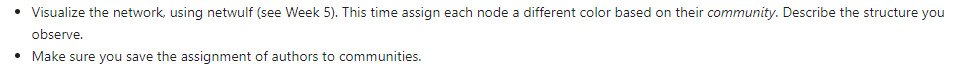

It is simply not feasible to create a distinguishable colour palette of 151 colours. I kept it to five colours instead.

In [18]:
#Splitting the communities into 5 segments 
com_list = list(set(partition.values()))
split_len = len(set(partition.values())) // 5

# Use list comprehensions to split the list into 5 parts
com_split = [com_list[i:i+split_len] for i in range(0, len(com_list), split_len-4)]

#Setting up colorcoding
colors = ['#f00000', "#6EE1C9", '#000000', '#8185FF', "#a3b426"] #red, teal, black, purple'ish, yellow-green
color_dic = {}

for i in range(len(partition.values())):
    if list(partition.values())[i] in com_split[0]:
        color_dic[list(partition.keys())[i]] = colors[0]
    elif list(partition.values())[i] in com_split[1]:
        color_dic[list(partition.keys())[i]] = colors[1]
    elif list(partition.values())[i] in com_split[2]:
        color_dic[list(partition.keys())[i]] = colors[2]
    elif list(partition.values())[i] in com_split[3]:
        color_dic[list(partition.keys())[i]] = colors[3]
    else:
        color_dic[list(partition.keys())[i]] = colors[4] 
color_dic
nx.set_node_attributes(G, color_dic, 'color')

#Using nx.visualize(G) to create figure

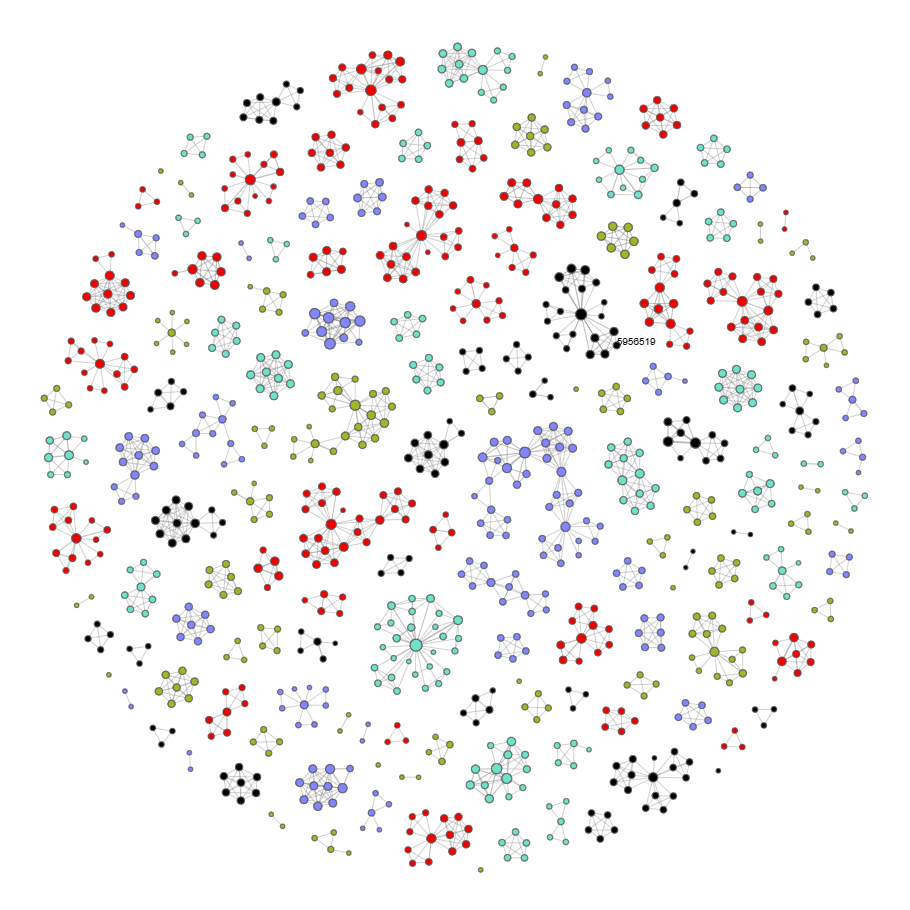

In [19]:
from IPython.display import Image
Image("network_finale.png")

The network consists of many small clusters varying in size. Judging by this I ended up with many authors, who likely have only written one or few papers as there are a lot clusters with less than 5 nodes. Also, even many of the nodes related to the large clusters have low degree signifying I have either ended up with few papers or authors who have only been accredited for few - unless they happen to really enjoy working only with the same person time and time again. Some of the bigger clusters contain one big node (sized by degrees), indicating that author is likely to have contributed to many different collaborations as they also tend to be the center of the cluster. This is especially evidenced by the black cluster top-mid-right hand side (where a tag made its way into the graph somehow), where it would seem one person has been participating in 5 different collaborations with each surrounding "subcluster" as the others have no connection than except through that one author. Since multiple communities have the same colour it is not possible to confirm that the partitioning identified the same patterns of the data consisting of many small clusters, but it seems likely that is how it achieved a modularity of almost 1. Worth noting is also the many single dots showing that some authors have no collaborations, and likely also the reason the partitioning creates 151 communities.

# Part 3:

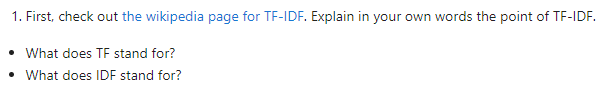 

TF (Term Frequency) is amount of times a given word or term appears in the analyzed text or corpus divided by the total amount of words. This then, becomes a frequency of the given term and can be used when analyzing only a single text identifying the topological words and from this what the text is about. Though, this requires some filtering as the frequency of common non-topological words such as "the", "a", and "is" are likely to dominate the top of the frequencies with the relevant terms being less apparent. Therefore, this method requires some knowledge beforehand to be fully utilized.

Inverse Document Frequency (IDF) is an expression of how often a term appears across a set of text, documents etc. Given a set of texts - such as the Shakespeare's 37 plays - a second score, df (document frequency?) is kept noting if a word appeared (even just once) in a text. The IDF is then calculated by log(N / DF). "Romeo" only appears in Romeo and Juliet, thus the IDF of Romeo is log(37 / 1). This definition allows for a distinguishable score where the former non-relevant words of "the", "a", and "is" will score low as they are appear in nearly all texts but the rare words will be assigned a high score. IDF can then be used to detect the rate of relevant words (given the question/circumstances) between two or more sets of texts.

# 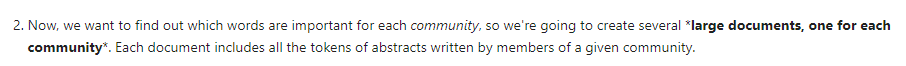

As mentioned briefly earlier. I've had my fair share of issues with the API and I have no author ID in my abstract data set, making it a tiresome task to merge back and forth to subtract them and I have two other assigments for wednesday to do. Instead, I am going to modify this assignment slightly by using the titles of their works instead. For this I have used pandas explode on the papers dataset resulting in 4 187 015 rows, where I have used the NTLK and re libraries to tokenize the titles removing any capital letters, URL's, stop words, and punctuations while making everything lower case. Below is a snippet of the outcome. 

In [20]:
import pandas as pd
df = pd.read_csv("token_title.csv")
set(df["token"][:100])

{'computational inflection scientific discovery',
 'delphi towards machine ethics norms',
 'iconary pictionary-based game testing multimodal communication drawings text',
 'infrastructure rapid open knowledge network development',
 'next big challenges core ai technology',
 'semantic scholar open data platform',
 'virtual communities real'}

# 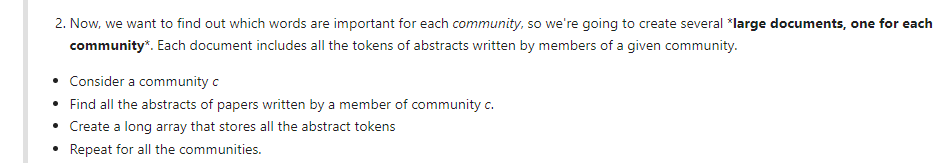

In [21]:
#We save ourselves some computing time
df = df[df["authors"].isin(list(partition.keys()))]
df = df.reset_index(drop=True)

#Initalizing the token_list
token_list = [list() for n in range(len(set(partition.values())))]
token_count = [0 for n in range(len(set(partition.values())))]
author_count = [0 for n in range(len(set(partition.values())))]

#Search through the nodes...
for node in partition.keys():
    author_count[int(partition[node])] += 1
    #Search through the authors...
    for i in range(len(df)):
        #Making sure text only enters into community once
        if df["token"][i] not in token_list[int(partition[node])]:
            #See if they match...
            if df["authors"][i] == node:
                #Add them to the list
                token_list[int(partition[node])].append(str(df["token"][i]))
                token_count[int(partition[node])] += 1

# 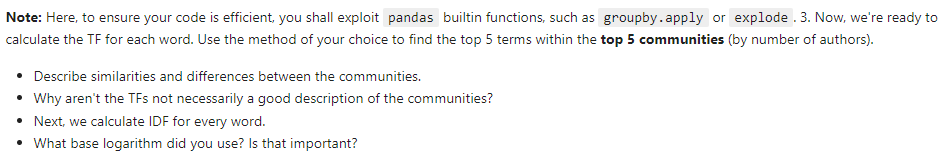

In [22]:
#Turning it into long string for TF
a = token_list
token_str_list = ["" for i in range(len(a))]
for i in range(len(a)):
    for j in range(len(a[i])):
        token_str_list[i] += a[i][j] + " "

#Setting up the token dataframe
c = [n for n in range(len(token_list))]

d = {'community': c,'authors': author_count, 'token_count': token_count,'tokens': token_list,'token_strings':token_str_list,'TF':0}
dft = pd.DataFrame(data=d)

import nltk
from nltk.tokenize import word_tokenize
from collections import Counter

#Creating function to calculate the TFs and pass to apply function later
def TF_calc(x):
    # Tokenize the document into individual words
    words = word_tokenize(x.lower())
    word_counts = Counter(words)

    # Calculate the term frequency of each word
    total_words = len(words)
    tf = [] 
    #Passing it as a string to more easily split and explode
    for word in word_counts:
        tf.append(word+" : " + str(word_counts[word] / total_words))
    return tf

#Calculating the TF
dft["TF"] = dft["token_strings"].apply(lambda x: TF_calc(x)) 

#Dataframe explode, split by the " : " to create 2 rows of TF and term. Ensure TF is the right type.
dft = dft.explode('TF',ignore_index = True)
split = dft["TF"].str.split(" : ",expand=True)
dft["term"],dft["TF"] = split[0],split[1]
dft["TF"] = dft["TF"].apply(lambda x: float(x))

# To find the top 5 communities
top5 = list(set(dft["authors"].to_list()))[-5:]
df5 = dft[dft["authors"].isin(top5)]
INDEX = df5.groupby(['community'])['TF'].nlargest(5).reset_index(drop=False)["level_1"].to_list()
df5 = dft.iloc[INDEX]

In [23]:
df5.groupby(["term","community"]).sum()

authors  token_count        TF
term         community                                
``           2               23          118  0.010965
analysis     59              20          123  0.012165
consent      27              20           99  0.010724
data         27              20           99  0.012064
             70              37          354  0.010448
de           70              37          354  0.011194
designing    27              20           99  0.010724
digital      47              28          106  0.014545
dynamics     114             21           79  0.026104
electronic   47              28          106  0.021818
energy       27              20           99  0.012064
evolutionary 114             21           79  0.022088
fairness     70              37          354  0.010075
governance   47              28          106  0.024242
government   47              28          106  0.029091
health       2               23          118  0.013158
home         2               23          118  0.010965
information  47              28          106  0.016970
model        114             21           79  0.024096
network      59              20          123  0.025547
networks     59              20          123  0.046229
             70              37          354  0.014179
             114             21           79  0.034137
online       2               23          118  0.008772
research     27              20           99  0.009383
social       59              20          123  0.019465
             70              37          354  0.014179
             114             21           79  0.020080
support      2               23          118  0.009868
trust        59              20          123  0.015815

Most notably is the how difficult is it to identify similiarities. Throughout these 5 communities only 3 words appear in multiple communities with "networks", "social", and "data", which would not lead one to believe these five groups likely have computational social science as their common interest. Even within those three it also varies how often a term is used as the TF for "networks" is 0.046 for community 20, but for community 84 is only 0.014. Considering a more topological approach it would probably be a decent guess to say both community 47 and 2 probably concerns themselves with health, but otherwise is just a collection of technology lingo, which is a weakness of TF of not filtering enough as I can still not make out what these various community concerns themselves with other than the broad terms of "technology" and "research".

Since I already counted the amount of tokens in the corpus calculating the IDF should be straight forward using the inbuilt count() function of Python.

In [24]:
#idf_term = log(N / amount of times term appears in N)
dft["idf"] = dft.apply(lambda x: np.log(x.token_count/x.token_strings.count(x.term)), axis=1)

For this I just used the standard ln from NumPy for ease. The base log acts as the scaling of the idf where an increase in base of the logarithm results in lower values of IDF. Vice versa, the values will increase given a decrease of base number for the logarithm, but results will be kept consistent (i.e. one word will not get a higher idf than another word by changing the log) throughout the calculations regardless of logarithm choice in both cases. Though, depending on the values present inside of the logarithm some log values may be more suitable than others for more comprehensible results.

# 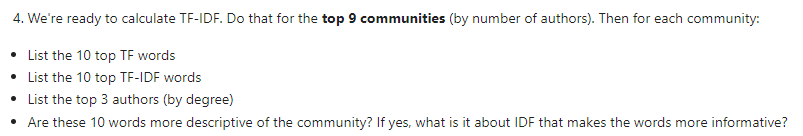

In [25]:
#TF-IDF is simply the product of the TF and IDF
dft["tf-idf"] = dft.apply(lambda x: x.TF * x.idf, axis=1)

In [26]:
# To find the top 9 communities
top9 = list(set(dft["authors"].to_list()))[-7:] #Multiple communities have equal amount of authors. Luckily -7 fits perfect.
#find communities with that amount of authors
df9 = dft[dft["authors"].isin(top9)]
INDEX = df9.groupby(['community'])['TF'].nlargest(10).reset_index(drop=False)["level_1"].to_list()
#subtract them and reset index for printing
df9 = dft.iloc[INDEX]
df9 = df9.reset_index()

## Top 10 TF

In [27]:
for i in range(90):
    if i % 9 == 0:
        print("\nFor community",df9["community"][i], "the top 10 words by TF are:")
        a = df9[["term","TF"]][i:i+9+1].sort_values("TF",ascending=False)
        a = a["term"].to_list()
        print(a)


For community 2 the top 10 words by TF are:
['health', 'home', '``', 'support', 'online', 'social', 'research', 'technology', 'design', 'development']

For community 2 the top 10 words by TF are:
['covid-19', 'influenza', 'social', 'disease', 'united', 'models', 'study', 'states', 'agent-based', 'development']

For community 5 the top 10 words by TF are:
['hate', 'social', 'networks', 'media', 'speech', 'study', 'agent-based', 'modeling', 'scientific', 'analysis']

For community 13 the top 10 words by TF are:
['data', 'energy', 'designing', 'consent', 'analysis', 'research', 'work', 'smart', 'deep', 'framework']

For community 27 the top 10 words by TF are:
['government', 'governance', 'electronic', 'information', 'digital', 'public', 'smart', 'future', 'disaster', 'user']

For community 47 the top 10 words by TF are:
['networks', 'network', 'social', 'trust', 'public', 'sustainable', 'analysis', 'social', 'framework', 'data']

For community 59 the top 10 words by TF are:
['semantic',

## Top 10 IDF 

In [28]:
# To find the top 9 communities
top9 = list(set(dft["authors"].to_list()))[-7:] #Multiple communities have equal amount of authors. Luckily -7 fits perfect.
#find communities with that amount of authors
df9 = dft[dft["authors"].isin(top9)]
INDEX = df9.groupby(['community'])['tf-idf'].nlargest(10).reset_index(drop=False)["level_1"].to_list()
#subtract them and reset index for printing
df9 = dft.iloc[INDEX]
df9 = df9.reset_index()

for i in range(90):
    if i % 9 == 0:
        print("\nFor community",df9["community"][i], "the top 10 words by TF-IDF are:")
        a = df9[["term","tf-idf"]][i:i+9+1].sort_values("tf-idf",ascending=False)
        a = a["term"].to_list()
        print(a)


For community 2 the top 10 words by TF-IDF are:
['``', 'home', 'health', 'online', 'social', 'support', 'research', 'technology', 'development', 'designing']

For community 2 the top 10 words by TF-IDF are:
['influenza', 'covid-19', 'united', 'models', 'social', 'disease', 'agent-based', 'modeling', 'study', 'designing']

For community 5 the top 10 words by TF-IDF are:
['social', 'hate', 'networks', 'media', 'speech', 'study', 'scientific', 'study', 'states', 'analysis']

For community 13 the top 10 words by TF-IDF are:
['energy', 'designing', 'consent', 'data', 'research', 'future', 'analysis', 'disaster', 'deep', 'framework']

For community 27 the top 10 words by TF-IDF are:
['governance', 'electronic', 'information', 'government', 'digital', 'public', 'disaster', 'flight', 'smart', '``']

For community 47 the top 10 words by TF-IDF are:
['networks', 'social', 'analysis', 'public', 'sustainable', 'trust', 'complex', 'social', 'framework', 'data']

For community 59 the top 10 words b

Generally a lot of words are repetitions and the ordering is the only change, but this in itself could perhaps be a better indicator of the communities prefered field of study as the entire community as the TF-IDF is an indication of how many times a word appears in a title across the corpus. By eye I cannot recognise much change beyond that except a word here and there such as "de" disappearing from community 61 and '"' being even more important. One thing that is more apparent by the increased amount of words and communities

## Top 3 authors

In [29]:
degree_dic = nx.degree_centrality(G)

# Sort dic desending. Get 3 first nodes.
top_nodes = sorted(degree_dic, key=degree_dic.get, reverse=True)[:3]
print("Top authors by degree are",top_nodes)

Top authors by degree are ['145280621', '145282573', '3015736']


# 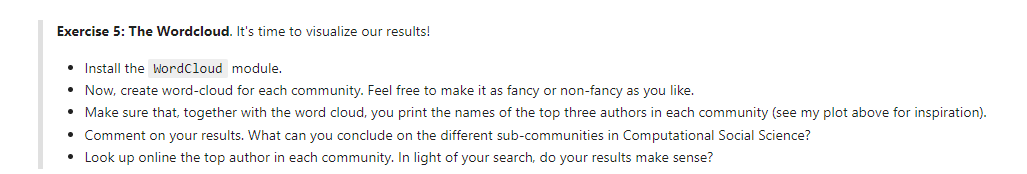

It seems a fair amount of excessive to create 151 Word Clouds. Instead I will go with the top 5 (or 6 rather) communities found earlier.

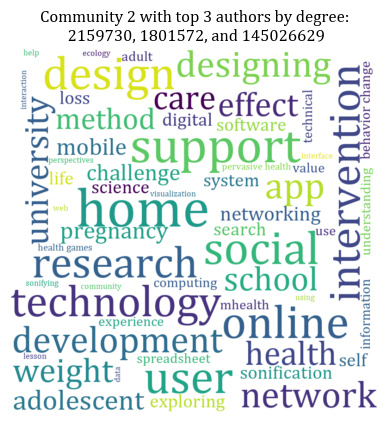

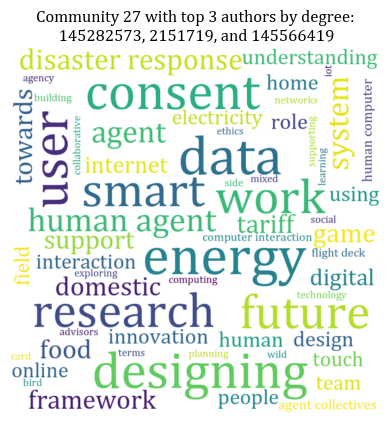

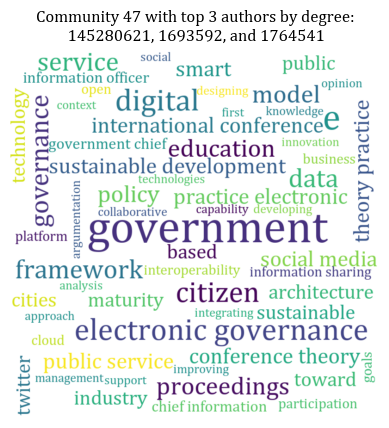

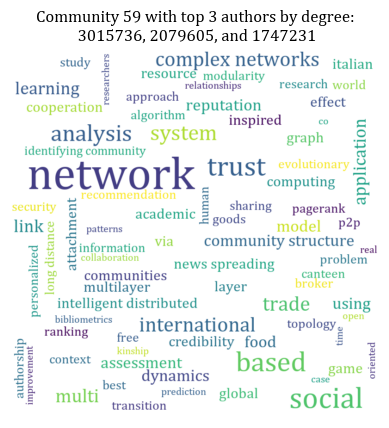

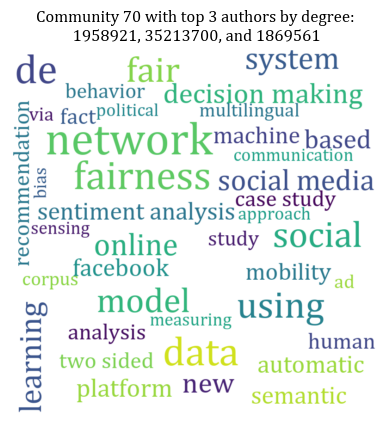

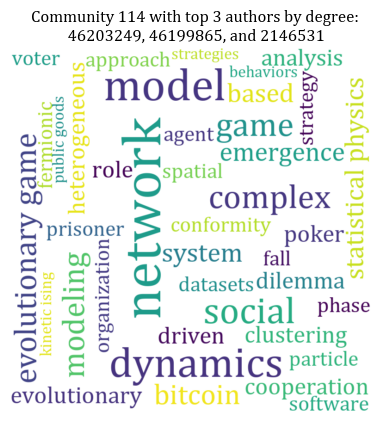

In [162]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

df_wc = df5.drop_duplicates(subset=["community"])
df_wc = df_wc.reset_index()

max_words = [60,60,60,80,40,40]
max_fonts = [120,120,100,100,100,120,120]

author_pick_up = []

for i in range(len(df_wc)):
    #Grabbing the nodes with highest degree
    com_nodes = [n for n, attr in G.nodes(data=True) if attr['community'] == df_wc["community"][i]]
    degree_dic = {n: d for n, d in G.degree(com_nodes)}
    # Sort dic desending. Get 3 first nodes.
    top_nodes = sorted(degree_dic, key=degree_dic.get, reverse=True)[:3]
    author_pick_up.append(top_nodes)
    PRETTY = str(top_nodes[0])+", "+str(top_nodes[1])+", and "+str(top_nodes[2])

    
    text = df_wc["token_strings"][i]
    wordcloud = WordCloud(max_font_size=max_fonts[i], font_path = 'cambria',height=800,width=800, max_words=max_words[i], background_color="white").generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    a = df_wc["community"][i]
    plt.title(f"Community {a} with top 3 authors by degree:\n {PRETTY}")
    plt.show()

All in all going by the titles the authors of each community have collaborated on it is not eaily discernible what each sub-community is researching other than technology, which comes to little surprise for a field with computational in the name. One way to alleviate this issue could be to more aggresively filter stop words that bear little new information such as "social", "network", "study" and the like. Other than that a meta comment about this whole analysis is the questionable data set on which it is founded, where information has been missing left and right due to my issues with the API of Semantic Scholar. Whether or not a particular characteristic of researchers I shall leave unanswered, but from the netwulf diagram (the ball) earlier it would lead to believe that many researcher have either not collaborated on many publications within the field, collaborate with the same people, or my data set is just skewing the results. Also, it is possible to achieve almost 1 in modularity showing a tendency of subcommunities or cliques. The assortativity coeffiecient of both the fields and the degress indicates that researcher in computational science tend to work people from other fields and with people of other degrees, though, both are not high above the randomness of 0.

In [173]:
#To look up authors
df_A = pd.read_excel("AUTHORD_ID.xlsx")
df_A["authorId"] = df_A["authorId"].apply(lambda x: str(x)[:-2])

In [182]:
#df_A[df_A["authorId"].isin(author_pick_up[5])]

Merely looking up the names from the posters it seems to coincide with my results with all the researcher being related to the more technical subjects - researchers within finance still specialised through technological means. Community 114 seemed to consist of people with Italian names, which would also be a natural reason for people to work together, i.e. within the same country. It did not appear for people to work at the same university (though, people may have changed jobs).